In [1]:
import pandas as pd
import requests as r
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

sys.path.append(os.path.abspath('..'))
from datetime import *     
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [12]:
DATA_PATHS = [f'../data/water_level/historical_data_202{i}.csv' for i in range(1,6)]
FULL_DATA_PATH = '../data/water_level/full_historical.csv'
SPLIT_DATE = pd.to_datetime('2025-02-01 00:00:00+00:00')
SAMPLE_START = pd.to_datetime('2024-01-01 00:00:00+00:00')
SAMPLE_END = pd.to_datetime('2025-01-01 00:00:00+00:00')

In [13]:
## -- INTERFACE METHODS -- 

def load_dataset(path):
    full_df = pd.read_csv(path)
    full_df['time'] = pd.to_datetime(full_df['time'])
    full_df = full_df.set_index('time')
    full_df = full_df.sort_index()
    full_df = full_df.drop(columns=['Unnamed: 0'])
    return full_df

def get_df_list(data_paths):
    df_list = [pd.read_csv(path) for path in data_paths]
    return df_list

def concat_data(df_list):
    reversed_df_list = [df.iloc[::-1] for df in df_list]
    full_df = pd.concat(reversed_df_list, ignore_index=True)
    return full_df

def remove_outliers(df, column, threshold):
    mask = df[column].abs() < threshold
    df = df.loc[mask].copy()
    return df

def take_dataframe_subset(df, start=None, end=None):
    return df.loc[start:end]

def resample_dataframe(df, frequency = None):
    if frequency:
        df = df.resample(frequency).max().interpolate(method='linear').copy()
    return df

def break_long_lines(df, time_col='time', gap_threshold='1H'):
    
    if time_col not in df.columns and not isinstance(df.index, pd.DatetimeIndex):
         raise ValueError(f"DataFrame must have a '{time_col}' column or a DatetimeIndex.")
    
    if not isinstance(df.index, pd.DatetimeIndex):
        df = df.set_index(time_col)
        df.index = pd.to_datetime(df.index)

    threshold = pd.Timedelta(gap_threshold)
    time_diff = df.index.to_series().diff()
    gap_start_mask = time_diff > threshold
    df.loc[gap_start_mask, 'result'] = np.nan
    
    return df

def feature_engineering(df):
    df = df.sort_index()
    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("DataFrame index must be a DatetimeIndex.")
    
    df["year"] = df.index.year
    df["month"] = df.index.month
    df["day_of_week"] = df.index.dayofweek
    df["dayofyear"] = df.index.dayofyear
    df["hour"] = df.index.hour
    df["minute"] = df.index.minute
    df["weekofyear"] = df.index.isocalendar().week.astype(int)
    df["is_weekend"] = (df["day_of_week"] >= 5).astype(int)
    minutes_in_cycle = (df["hour"] * 60 + df["minute"]) % 720 
    bi_daily_angle = 2 * np.pi * minutes_in_cycle / 720
    df['bi_daily_sin'] = np.sin(bi_daily_angle)
    df['bi_daily_cos'] = np.cos(bi_daily_angle)
    df["day_of_month"] = df.index.day
    day_angle = 2 * np.pi * df["day_of_week"] / 7
    df['day_of_week_sin'] = np.sin(day_angle)
    df['day_of_week_cos'] = np.cos(day_angle)
    hour_angle = 2 * np.pi * df["hour"] / 24
    df['hour_sin'] = np.sin(hour_angle)
    df['hour_cos'] = np.cos(hour_angle)
    days_in_year = 366 if df.index.is_leap_year.any() else 365
    doy_angle = 2 * np.pi * df["dayofyear"] / days_in_year
    df['day_of_year_sin'] = np.sin(doy_angle)
    df['day_of_year_cos'] = np.cos(doy_angle)
    df["is_month_start"] = df.index.is_month_start.astype(int)
    df["is_month_end"] = df.index.is_month_end.astype(int)
    df['time_delta_sec'] = df.index.to_series().diff().dt.total_seconds().fillna(0)
    df["is_quarter_start"] = df.index.is_quarter_start.astype(int)
    df["is_quarter_end"] = df.index.is_quarter_end.astype(int)

    return df

def train_test_split(df, split_date):
    train_df = df[df.index < split_date].copy()
    test_df = df[df.index >= split_date].copy()
    return train_df, test_df

def prepare_df_prophet(df):
    index_name = df.index.name
    df = df.reset_index()
    df = df.rename(columns={
        index_name : 'ds',
        'target': 'y'
    })

    if df['ds'].dt.tz is not None:
        df['ds'] = df['ds'].dt.tz_localize(None)
        
    return df

In [14]:
## -- VISUALIZATION METHODS -- 

def visualize_time_series(df, X = None, title = "Time Series Plot"):
    if X == None:
        df.plot(figsize=(12,6), title=title)
    else:
        df.plot(x=X, figsize=(12,6), title=title)
    
    plt.xticks(rotation=45, ha='right') 
    plt.tight_layout()
    plt.show()

def visualize_histogram(series, title="Histogram"):
    series.plot(kind='hist', bins=500)
    plt.show()

def plot_outliers(df, threshold, column):
    mask = df[column].abs() > threshold
    ax = df.loc[mask, column].plot(figsize=(12, 6), style='.')
    ax.set_xlabel(df.index.name or "index")
    ax.set_ylabel("result")
    return ax

def visualize_split(df_train, df_test, split_date):
    plt.figure(figsize=(12,6))
    plt.plot(df_train['ds'], df_train['y'], label='Training Data', color='darkblue', linewidth=1.5)
    plt.plot(df_test['ds'], df_test['y'], label='Test Data', color='crimson', linewidth=1.5)
    plt.axvline(x=split_date, color='black', linestyle='--', linewidth=2, label='Split Date')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

def plot_forecast(df_train, forecasts, split_date):
    plt.figure(figsize=(12,6))
    plt.plot(df_train['ds'], df_train['y'], label='Training Data', color='darkblue', linewidth=1.5)
    plt.plot(forecasts['ds'], forecasts['yhat'], label='Forecasts', color='lightblue', linewidth=1.5)
    plt.axvline(x=split_date, color='black', linestyle='--', linewidth=2, label='Split Date')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

/var/folders/4v/q1spznf91t36ybznjd9h0g480000gn/T/ipykernel_18377/3135884148.py:30: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample(frequency).max().interpolate(method='linear').copy()


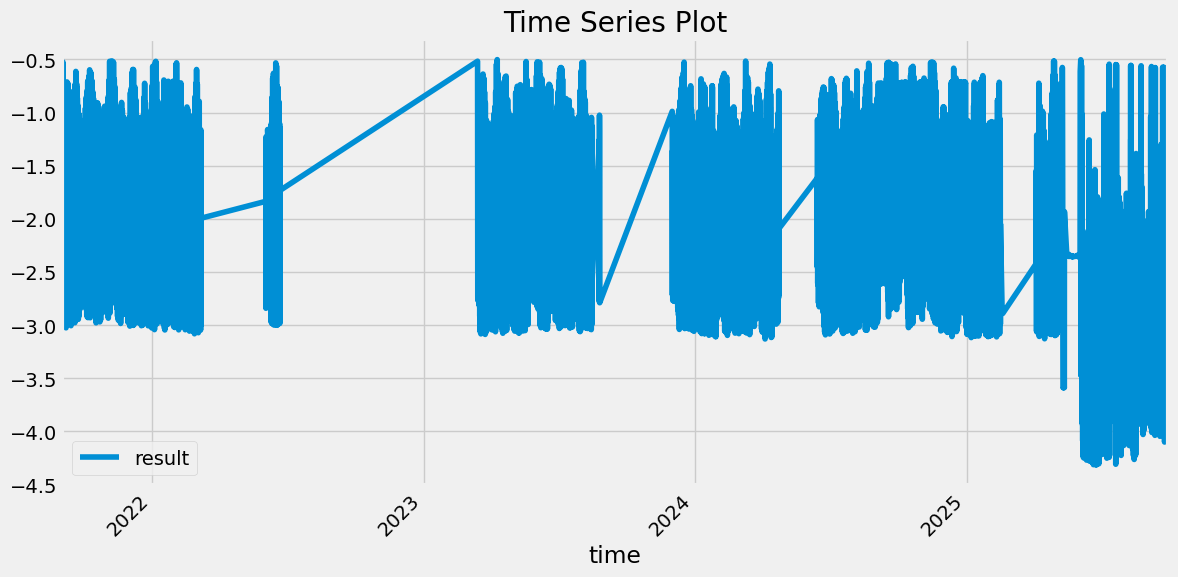

In [15]:
## -- Create Dataframe -- ## 

df = load_dataset(FULL_DATA_PATH)
df = resample_dataframe(df, frequency='1H')
df = take_dataframe_subset(df)
visualize_time_series(df)

In [16]:
df

,result
time,
2021-09-01 21:00:00+00:00,-1.696
2021-09-01 22:00:00+00:00,-0.968
2021-09-01 23:00:00+00:00,-0.968
2021-09-02 00:00:00+00:00,-0.969
2021-09-02 01:00:00+00:00,-2.011
...,...
2025-09-28 19:00:00+00:00,-2.440
2025-09-28 20:00:00+00:00,-2.478
2025-09-28 21:00:00+00:00,-2.723


In [17]:
print(df['result'].describe())

count    35715.000000
mean        -1.843327
std          0.719909
min         -4.316000
25%         -2.389000
50%         -1.803000
75%         -1.282000
max         -0.501000
Name: result, dtype: float64
